In [70]:
from typing import Iterable
import datetime

In [71]:
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import rdkit
from rdkit.Chem.MolStandardize import rdMolStandardize
import polars as pl
print(rdkit.__version__)

2023.09.1


In [72]:
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [73]:
def enumerate_tauts(sml):
    enumerators = [rdMolStandardize.TautomerEnumerator(), rdMolStandardize.GetV1TautomerEnumerator()]
    smls_tauts = [{} for _ in enumerators]
    for i, enumerator in enumerate(enumerators):
        mol = Chem.MolFromSmiles(sml)
        tauts = enumerator.Enumerate(mol)
        for taut in tauts:
            smls_tauts[i].update({Chem.MolToSmiles(taut):taut})
    return smls_tauts

In [74]:
def check_same_keys(dict_list):
    start = datetime.datetime.now()
    # Check if the list is empty or has only one dictionary
    if len(dict_list) < 2:
        return True

    # Get the keys of the first dictionary in the list
    reference_keys = set(dict_list[0].keys())

    # Iterate through the dictionaries starting from the second one
    for dictionary in dict_list[1:]:
        # Check if the keys of each dictionary match the keys of the reference dictionary
        if set(dictionary.keys()) != reference_keys:
            # Return False if keys are not the same
            return False
    # Return True if all dictionaries have the same keys
    # print(f"check_same_keys took {datetime.datetime.now() - start} seconds")
    return True

Algorithm for processing Tautomer_database_release_3a:
1) Remove duplicate (keep only one row) Ref values--at initial inspection, seems like duplicate rows contain the same SMILES for SMILES_n OR keep all rows for a Ref, putting all the SMILES into a set 
2) For each row corresponding to a Ref,
    1) Read Size value
    2) Extract columns SMILES_n where n = 1 to Size
    3) Convert extracted SMILES_n to canonical using RDKit
    4) Use those several SMILES_n columns as experimental tautomers by creating a set of SMILES_n (or dictionary of SMILES_n:mol ?)
    5) Use only SMILES_1 to enumerate tautomers using various cheminformatics algorithms
    6) Compare experimental to cheminformatics results: Are there differences in count and canonical SMILES?

In [75]:
file_name = "../data/Tautomer_database_release_3a.xlsx"
# file_name = "../data/Tautomer_database_release_3a_first.xlsx"
sheet_name = "Tautomer_database"
# file_name = "../data/8.sk.smi"
# file_name = "../data/12.sk.smi"

In [76]:
def canon_sml_or_none(mol):
    if mol is None:
        return None
    return Chem.MolToSmiles(mol)

In [96]:
df = pl.read_excel(
    source=file_name, 
    sheet_name=sheet_name,
    read_csv_options={"infer_schema_length":10000},
    )
SMILES_columns = [col for col in df.columns if col.startswith('SMILES_')]
InChI_columns = [col for col in df.columns if col.startswith('Std_InChI_')]

numbered_columns = []
for i, SMILES_column in enumerate(SMILES_columns):
    numbered_columns.append(SMILES_column)
    numbered_columns.append(InChI_columns[i])

df = df.select("Ref","Size",*numbered_columns)
print(df.sort("Ref"))
print(df.filter(pl.col("Ref") == 4))
df_melted = df.melt(id_vars=["Ref","Size"], value_vars=SMILES_columns[:2], value_name="sml")
df_melted
df_melted = df_melted.filter(pl.col('sml').is_not_null())

df_melted = df_melted.drop("variable")
df_melted = df_melted.unique()
df_melted = df_melted.with_columns(
    [
        pl.col("sml").map_elements(lambda s: Chem.MolFromSmiles(s)).alias("mol"),
    ]
)

df_melted = df_melted.with_columns(
    [
        pl.col("mol").map_elements(lambda m: canon_sml_or_none(m)).alias("canon_sml"),
    ]
)
print("df_melted, Ref=4")
print(df_melted.filter(pl.col("Ref") == 4))

df_melted = df_melted.drop("sml").drop_nulls()
df_melted = df_melted.unique("canon_sml")

df_melted = df_melted.sort("Ref")
with pl.Config(fmt_str_lengths=1000):
    print(df_melted)

shape: (2_820, 12)
┌──────┬──────┬───────────────┬──────────────┬───┬──────────┬─────────────┬──────────┬─────────────┐
│ Ref  ┆ Size ┆ SMILES_1      ┆ Std_InChI_1  ┆ … ┆ SMILES_4 ┆ Std_InChI_4 ┆ SMILES_5 ┆ Std_InChI_5 │
│ ---  ┆ ---  ┆ ---           ┆ ---          ┆   ┆ ---      ┆ ---         ┆ ---      ┆ ---         │
│ i64  ┆ i64  ┆ str           ┆ str          ┆   ┆ str      ┆ str         ┆ str      ┆ str         │
╞══════╪══════╪═══════════════╪══════════════╪═══╪══════════╪═════════════╪══════════╪═════════════╡
│ null ┆ null ┆ null          ┆ null         ┆ … ┆ null     ┆ null        ┆ null     ┆ null        │
│ 1    ┆ 2    ┆ O=C(C)CC(C)=O ┆ InChI=1S/C5H ┆ … ┆ null     ┆ null        ┆ null     ┆ null        │
│      ┆      ┆               ┆ 8O2/c1-4(6)3 ┆   ┆          ┆             ┆          ┆             │
│      ┆      ┆               ┆ -5(2)7/h…    ┆   ┆          ┆             ┆          ┆             │
│ 1    ┆ 2    ┆ C/C(O)=C/C(C) ┆ InChI=1S/C5H ┆ … ┆ null     ┆ null      

In [94]:
df_melted.filter(pl.col("Ref") == 4)

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,tauts_same
i64,i64,object,str,list[str],list[str],i64,i64,bool


In [78]:
def smls_tauts(
        enumerator,
        mol,
    ):
    tauts = enumerator.Enumerate(mol)
    tauts_dict = dict()
    for taut in tauts:
        tauts_dict.update({Chem.MolToSmiles(taut):taut})
    return tauts_dict

In [79]:
def tauts_list(
        enumerator,
        mol,
    ):
    tauts = enumerator.Enumerate(mol)
    tauts_list = []
    for taut in tauts:
        tauts_list.append(taut)
    return tauts_list

In [80]:
def tauts_as_sml_list(
        enumerator,
        mol,
    ):
    tauts = enumerator.Enumerate(mol)
    tauts_as_sml_list = []
    for taut in tauts:
        tauts_as_sml_list.append(Chem.MolToSmiles(taut))
    
    # Make smls into a set to remove duplicates, then back into a list so can be in dataframe
    tauts_as_sml_list = list(set(tauts_as_sml_list))
    return tauts_as_sml_list

In [81]:
# Enumerate tautomers
enumerators = [rdMolStandardize.TautomerEnumerator, rdMolStandardize.GetV1TautomerEnumerator]
for i, enumerator in enumerate(enumerators):
    df_melted = df_melted.with_columns(
        [
            pl.col("mol").map_elements(lambda m: tauts_as_sml_list(enumerator(), m)).alias("tauts" + enumerator.__name__),
        ]
    )
df_melted

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator
i64,i64,object,str,list[str],list[str]
1,2,<rdkit.Chem.rdchem.Mol object at 0x147457a70>,"""CC(=O)CC(C)=O""","[""C=C(O)CC(=C)O"", ""CC(=O)CC(C)=O"", … ""C=C(O)C=C(C)O""]","[""C=C(O)CC(=C)O"", ""CC(=O)CC(C)=O"", … ""C=C(O)C=C(C)O""]"
1,2,<rdkit.Chem.rdchem.Mol object at 0x1474059a0>,"""CC(=O)/C=C(/C)…","[""C=C(O)CC(=C)O"", ""CC(=O)CC(C)=O"", … ""C=C(O)C=C(C)O""]","[""C=C(O)CC(=C)O"", ""CC(=O)CC(C)=O"", … ""C=C(O)C=C(C)O""]"
2,2,<rdkit.Chem.rdchem.Mol object at 0x1474fe490>,"""c1cn[nH]n1""","[""c1cn[nH]n1"", ""c1c[nH]nn1""]","[""c1cn[nH]n1"", ""c1c[nH]nn1""]"
2,2,<rdkit.Chem.rdchem.Mol object at 0x1474de6c0>,"""c1c[nH]nn1""","[""c1cn[nH]n1"", ""c1c[nH]nn1""]","[""c1cn[nH]n1"", ""c1c[nH]nn1""]"
3,2,<rdkit.Chem.rdchem.Mol object at 0x1474f1c40>,"""Cc1cc[nH]n1""","[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]","[""C=C1CC=NN1"", ""Cc1cc[nH]n1"", … ""Cc1ccn[nH]1""]"
3,2,<rdkit.Chem.rdchem.Mol object at 0x1474e4820>,"""Cc1ccn[nH]1""","[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]","[""C=C1CC=NN1"", ""Cc1cc[nH]n1"", … ""Cc1ccn[nH]1""]"
5,3,<rdkit.Chem.rdchem.Mol object at 0x147400c80>,"""CC1(C)[C@@H]2C…","[""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O""]","[""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O""]"
5,3,<rdkit.Chem.rdchem.Mol object at 0x14746e960>,"""CC1(C)[C@@H]2C…","[""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O""]","[""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O""]"
6,3,<rdkit.Chem.rdchem.Mol object at 0x1474b5000>,"""O=C(/C=C(\O)c1…","[""O=C1CC=CC=C1C(=O)CC(=O)c1cccc2ccccc12"", ""O=C(C=C(O)C1C=CC=CC1=O)c1cccc2ccccc12"", … ""O=C1C=CCC=C1C(=O)CC(=O)c1cccc2ccccc12""]","[""O=C1CC=CC=C1C(=O)CC(=O)c1cccc2ccccc12"", ""O=C(C=C(O)C1C=CC=CC1=O)c1cccc2ccccc12"", … ""O=C1C=CCC=C1C(=O)CC(=O)c1cccc2ccccc12""]"


In [83]:
# Merge tautomer smls for each row for same ref: 
#   assumption is that all input smls correspond to legitimate tautomers
df_melted_aggregated = (
    df_melted.groupby('Ref').agg(pl.col("tautsTautomerEnumerator"), pl.col("tautsGetV1TautomerEnumerator"))
)

/var/folders/9w/cn8tqbv976gckxd0c9cbr1sw0000gn/T/ipykernel_67835/2950540124.py:4: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  df_melted.groupby('Ref').agg(pl.col("tautsTautomerEnumerator"), pl.col("tautsGetV1TautomerEnumerator"))


In [93]:
df_melted_aggregated.sort("Ref")

Ref,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator
i64,list[list[str]],list[list[str]]
1,"[[""C=C(O)CC(=C)O"", ""CC(=O)CC(C)=O"", … ""C=C(O)C=C(C)O""], [""C=C(O)CC(=C)O"", ""CC(=O)CC(C)=O"", … ""C=C(O)C=C(C)O""]]","[[""C=C(O)CC(=C)O"", ""CC(=O)CC(C)=O"", … ""C=C(O)C=C(C)O""], [""C=C(O)CC(=C)O"", ""CC(=O)CC(C)=O"", … ""C=C(O)C=C(C)O""]]"
2,"[[""c1cn[nH]n1"", ""c1c[nH]nn1""], [""c1cn[nH]n1"", ""c1c[nH]nn1""]]","[[""c1cn[nH]n1"", ""c1c[nH]nn1""], [""c1cn[nH]n1"", ""c1c[nH]nn1""]]"
3,"[[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""], [""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]]","[[""C=C1CC=NN1"", ""Cc1cc[nH]n1"", … ""Cc1ccn[nH]1""], [""C=C1CC=NN1"", ""Cc1cc[nH]n1"", … ""Cc1ccn[nH]1""]]"
5,"[[""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O""], [""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O""]]","[[""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O""], [""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O""]]"
6,"[[""O=C1CC=CC=C1C(=O)CC(=O)c1cccc2ccccc12"", ""O=C(C=C(O)C1C=CC=CC1=O)c1cccc2ccccc12"", … ""O=C1C=CCC=C1C(=O)CC(=O)c1cccc2ccccc12""], [""O=C1CC=CC=C1C(=O)CC(=O)c1cccc2ccccc12"", ""O=C(C=C(O)C1C=CC=CC1=O)c1cccc2ccccc12"", … ""O=C1C=CCC=C1C(=O)CC(=O)c1cccc2ccccc12""]]","[[""O=C1CC=CC=C1C(=O)CC(=O)c1cccc2ccccc12"", ""O=C(C=C(O)C1C=CC=CC1=O)c1cccc2ccccc12"", … ""O=C1C=CCC=C1C(=O)CC(=O)c1cccc2ccccc12""], [""O=C1CC=CC=C1C(=O)CC(=O)c1cccc2ccccc12"", ""O=C(C=C(O)C1C=CC=CC1=O)c1cccc2ccccc12"", … ""O=C1C=CCC=C1C(=O)CC(=O)c1cccc2ccccc12""]]"
8,"[[""O=C(C=C(O)c1ccccc1)c1ccccc1"", ""O=C(CC(=O)c1ccccc1)c1ccccc1""]]","[[""O=C(C=C(O)c1ccccc1)c1ccccc1"", ""O=C(CC(=O)c1ccccc1)c1ccccc1""]]"
9,"[[""O=C1C=Cc2ccccc2C1C=Nc1ccc([N+](=O)[O-])cc1"", ""O=[N+]([O-])c1ccc(N=Cc2c(O)ccc3ccccc23)cc1"", ""O=C1C=Cc2ccccc2C1=CNc1ccc([N+](=O)[O-])cc1""], [""O=C1CC=c2ccccc2=C1C=Nc1ccc([N+](=O)[O-])cc1"", ""O=C1C=Cc2ccccc2C1C=Nc1ccc([N+](=O)[O-])cc1"", … ""O=C1C=Cc2ccccc2C1=CNc1ccc([N+](=O)[O-])cc1""]]","[[""O=C1C=Cc2ccccc2C1C=Nc1ccc([N+](=O)[O-])cc1"", ""O=[N+]([O-])c1ccc(N=Cc2c(O)ccc3ccccc23)cc1"", ""O=C1C=Cc2ccccc2C1=CNc1ccc([N+](=O)[O-])cc1""], [""O=C1C=Cc2ccccc2C1C=Nc1ccc([N+](=O)[O-])cc1"", ""O=[N+]([O-])c1ccc(N=Cc2c(O)ccc3ccccc23)cc1"", ""O=C1C=Cc2ccccc2C1=CNc1ccc([N+](=O)[O-])cc1""]]"
10,"[[""CC(=O)c1ccc(N=CC2C(=O)C=Cc3ccccc32)cc1"", ""C=C(O)c1ccc(NC=C2C(=O)C=Cc3ccccc32)cc1"", … ""C=C(O)c1ccc(N=CC2C(=O)C=Cc3ccccc32)cc1""], [""CC(=O)c1ccc(N=CC2C(=O)C=Cc3ccccc32)cc1"", ""C=C(O)c1ccc(NC=C2C(=O)C=Cc3ccccc32)cc1"", … ""C=C(O)c1ccc(N=CC2C(=O)C=Cc3ccccc32)cc1""]]","[[""CC(=O)c1ccc(N=CC2C(=O)C=Cc3ccccc32)cc1"", ""C=C(O)c1ccc(NC=C2C(=O)C=Cc3ccccc32)cc1"", … ""C=C(O)c1ccc(N=CC2C(=O)C=Cc3ccccc32)cc1""], [""CC(=O)c1ccc(N=CC2C(=O)C=Cc3ccccc32)cc1"", ""C=C(O)c1ccc(NC=C2C(=O)C=Cc3ccccc32)cc1"", … ""C=C(O)c1ccc(N=CC2C(=O)C=Cc3ccccc32)cc1""]]"
11,"[[""O=C1C=Cc2ccccc2C1C=Nc1ccccc1"", ""O=C1C=Cc2ccccc2C1=CNc1ccccc1"", … ""Oc1ccc2ccccc2c1C=Nc1ccccc1""], [""O=C1C=Cc2ccccc2C1C=Nc1ccccc1"", ""O=C1C=Cc2ccccc2C1=CNc1ccccc1"", ""Oc1ccc2ccccc2c1C=Nc1ccccc1""], [""O=C1C=Cc2ccccc2C1C=Nc1ccccc1"", ""O=C1C=Cc2ccccc2C1=CNc1ccccc1"", ""Oc1ccc2ccccc2c1C=Nc1ccccc1""]]","[[""O=C1C=Cc2ccccc2C1C=Nc1ccccc1"", ""O=C1C=Cc2ccccc2C1=CNc1ccccc1"", … ""Oc1ccc2ccccc2c1C=Nc1ccccc1""], [""O=C1C=Cc2ccccc2C1C=Nc1ccccc1"", ""O=C1C=Cc2ccccc2C1=CNc1ccccc1"", ""Oc1ccc2ccccc2c1C=Nc1ccccc1""], [""O=C1C=Cc2ccccc2C1C=Nc1ccccc1"", ""O=C1C=Cc2ccccc2C1=CNc1ccccc1"", ""Oc1ccc2ccccc2c1C=Nc1ccccc1""]]"


In [84]:
# Add tautomer counts
tauts_columns = [col for col in df_melted.columns if col.startswith('tauts')]
for tauts_column in tauts_columns:
    df_melted = df_melted.with_columns(
        [
            pl.col(tauts_column).map_elements(lambda t: len(t)).alias("n_" + tauts_column),
        ]
    )
df_melted

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator
i64,i64,object,str,list[str],list[str],i64,i64
1,2,<rdkit.Chem.rdchem.Mol object at 0x147457a70>,"""CC(=O)CC(C)=O""","[""C=C(O)CC(=C)O"", ""CC(=O)CC(C)=O"", … ""C=C(O)C=C(C)O""]","[""C=C(O)CC(=C)O"", ""CC(=O)CC(C)=O"", … ""C=C(O)C=C(C)O""]",5,5
1,2,<rdkit.Chem.rdchem.Mol object at 0x1474059a0>,"""CC(=O)/C=C(/C)…","[""C=C(O)CC(=C)O"", ""CC(=O)CC(C)=O"", … ""C=C(O)C=C(C)O""]","[""C=C(O)CC(=C)O"", ""CC(=O)CC(C)=O"", … ""C=C(O)C=C(C)O""]",5,5
2,2,<rdkit.Chem.rdchem.Mol object at 0x1474fe490>,"""c1cn[nH]n1""","[""c1cn[nH]n1"", ""c1c[nH]nn1""]","[""c1cn[nH]n1"", ""c1c[nH]nn1""]",2,2
2,2,<rdkit.Chem.rdchem.Mol object at 0x1474de6c0>,"""c1c[nH]nn1""","[""c1cn[nH]n1"", ""c1c[nH]nn1""]","[""c1cn[nH]n1"", ""c1c[nH]nn1""]",2,2
3,2,<rdkit.Chem.rdchem.Mol object at 0x1474f1c40>,"""Cc1cc[nH]n1""","[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]","[""C=C1CC=NN1"", ""Cc1cc[nH]n1"", … ""Cc1ccn[nH]1""]",2,5
3,2,<rdkit.Chem.rdchem.Mol object at 0x1474e4820>,"""Cc1ccn[nH]1""","[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]","[""C=C1CC=NN1"", ""Cc1cc[nH]n1"", … ""Cc1ccn[nH]1""]",2,5
5,3,<rdkit.Chem.rdchem.Mol object at 0x147400c80>,"""CC1(C)[C@@H]2C…","[""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O""]","[""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O""]",3,3
5,3,<rdkit.Chem.rdchem.Mol object at 0x14746e960>,"""CC1(C)[C@@H]2C…","[""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O""]","[""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O""]",3,3
6,3,<rdkit.Chem.rdchem.Mol object at 0x1474b5000>,"""O=C(/C=C(\O)c1…","[""O=C1CC=CC=C1C(=O)CC(=O)c1cccc2ccccc12"", ""O=C(C=C(O)C1C=CC=CC1=O)c1cccc2ccccc12"", … ""O=C1C=CCC=C1C(=O)CC(=O)c1cccc2ccccc12""]","[""O=C1CC=CC=C1C(=O)CC(=O)c1cccc2ccccc12"", ""O=C(C=C(O)C1C=CC=CC1=O)c1cccc2ccccc12"", … ""O=C1C=CCC=C1C(=O)CC(=O)c1cccc2ccccc12""]",14,14


In [85]:
def sets_are_equal(
        *iterables: Iterable,
):
    if len(iterables) < 2:
        return True

    # Convert iterables into sets
    iterables_list = [iterable for iterable in iterables]
    sets_list = [set(iterable) for iterable in iterables_list]

    # Get the keys of the first dictionary in the list
    reference_set = sets_list[0]

    # Iterate through the sets starting from the second one
    for this_set in sets_list[1:]:
        # Check if each set matches the reference set
        if this_set != reference_set:
            return False  # Return False if keys are not the same
    return True  # Return True if all dictionaries have the same keys

In [86]:
# Check if sets of tautomers are the same for different algorithms
df_melted = df_melted.with_columns(
    [
        pl.struct(["tautsTautomerEnumerator", "tautsGetV1TautomerEnumerator"]).
        map_elements(lambda x: sets_are_equal(x["tautsTautomerEnumerator"], x["tautsGetV1TautomerEnumerator"]))
        .alias("tauts_same"),
    ]
)
df_melted

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,tauts_same
i64,i64,object,str,list[str],list[str],i64,i64,bool
1,2,<rdkit.Chem.rdchem.Mol object at 0x147457a70>,"""CC(=O)CC(C)=O""","[""C=C(O)CC(=C)O"", ""CC(=O)CC(C)=O"", … ""C=C(O)C=C(C)O""]","[""C=C(O)CC(=C)O"", ""CC(=O)CC(C)=O"", … ""C=C(O)C=C(C)O""]",5,5,true
1,2,<rdkit.Chem.rdchem.Mol object at 0x1474059a0>,"""CC(=O)/C=C(/C)…","[""C=C(O)CC(=C)O"", ""CC(=O)CC(C)=O"", … ""C=C(O)C=C(C)O""]","[""C=C(O)CC(=C)O"", ""CC(=O)CC(C)=O"", … ""C=C(O)C=C(C)O""]",5,5,true
2,2,<rdkit.Chem.rdchem.Mol object at 0x1474fe490>,"""c1cn[nH]n1""","[""c1cn[nH]n1"", ""c1c[nH]nn1""]","[""c1cn[nH]n1"", ""c1c[nH]nn1""]",2,2,true
2,2,<rdkit.Chem.rdchem.Mol object at 0x1474de6c0>,"""c1c[nH]nn1""","[""c1cn[nH]n1"", ""c1c[nH]nn1""]","[""c1cn[nH]n1"", ""c1c[nH]nn1""]",2,2,true
3,2,<rdkit.Chem.rdchem.Mol object at 0x1474f1c40>,"""Cc1cc[nH]n1""","[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]","[""C=C1CC=NN1"", ""Cc1cc[nH]n1"", … ""Cc1ccn[nH]1""]",2,5,false
3,2,<rdkit.Chem.rdchem.Mol object at 0x1474e4820>,"""Cc1ccn[nH]1""","[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]","[""C=C1CC=NN1"", ""Cc1cc[nH]n1"", … ""Cc1ccn[nH]1""]",2,5,false
5,3,<rdkit.Chem.rdchem.Mol object at 0x147400c80>,"""CC1(C)[C@@H]2C…","[""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O""]","[""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O""]",3,3,true
5,3,<rdkit.Chem.rdchem.Mol object at 0x14746e960>,"""CC1(C)[C@@H]2C…","[""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O""]","[""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O""]",3,3,true
6,3,<rdkit.Chem.rdchem.Mol object at 0x1474b5000>,"""O=C(/C=C(\O)c1…","[""O=C1CC=CC=C1C(=O)CC(=O)c1cccc2ccccc12"", ""O=C(C=C(O)C1C=CC=CC1=O)c1cccc2ccccc12"", … ""O=C1C=CCC=C1C(=O)CC(=O)c1cccc2ccccc12""]","[""O=C1CC=CC=C1C(=O)CC(=O)c1cccc2ccccc12"", ""O=C(C=C(O)C1C=CC=CC1=O)c1cccc2ccccc12"", … ""O=C1C=CCC=C1C(=O)CC(=O)c1cccc2ccccc12""]",14,14,true


In [87]:
df_melted_different = df_melted.filter(pl.col("tauts_same") == False)

df_melted_different = df_melted_different.with_columns(
    [
        pl.struct(["n_tautsTautomerEnumerator", "n_tautsGetV1TautomerEnumerator"]).
        map_elements(lambda x: abs(x["n_tautsTautomerEnumerator"] - x["n_tautsGetV1TautomerEnumerator"]))
        .alias("n_tauts_diff"),
    ]
)

df_melted_different.drop(["mol","tautsTautomerEnumerator", "tautsGetV1TautomerEnumerator"]).filter(pl.col("n_tauts_diff") < 5).sort("n_tauts_diff", descending=True)

Ref,Size,canon_sml,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,tauts_same,n_tauts_diff
i64,i64,str,i64,i64,bool,i64
73,2,"""CSC1=NC(C)=C(C…",4,8,false,4
73,2,"""CSC1=NC(c2cccc…",4,8,false,4
76,2,"""CCOC(=O)C1=C(C…",4,8,false,4
76,2,"""CCOC(=O)C1=C(C…",4,8,false,4
77,2,"""CCOC(=O)C1=C(C…",4,8,false,4
77,2,"""CCOC(=O)C1=C(C…",4,8,false,4
80,2,"""CC1=C(C(=O)OC(…",4,8,false,4
80,2,"""CC1=C(C(=O)OC(…",4,8,false,4
87,2,"""C1=C(c2ccccc2)…",1,5,false,4


In [88]:
def align_lists(
        list1,
        list2,
        filler = "",
):
    """Align list2 under list1, using filler for items in list1 not in list2, 
    for example:
    
    input:
    list1: a,  b,  c
    list2: a,  d,  c,  e,  f

    output:
    list2: a, "",  c,  d,  e,  f
    """
    # Determine index for each element in list2:
    list_2_indices = []
    list2_index_max = len(list1) - 1
    for _, list2_item in enumerate(list2):
        try:
            list2_index = list1.index(list2_item)
        except:
            list2_index_max += 1
            list2_index = list2_index_max
        print(f"{list2_item} will be placed in column {list2_index}")
        list_2_indices.append(list2_index)
    # Create sorted (with blanks) list2 by that ordering list
    list2_aligned = [filler] * (max(list_2_indices) + 1)
    for i, list_2_col in enumerate(list_2_indices):
        list2_aligned[list_2_col] = list2[i]
    return list2_aligned

In [89]:
df_melted_different_example = df_melted_different.filter(pl.col("Ref") == 888).filter(pl.col("canon_sml").str.starts_with("COc1c(O)c2c"))
df_melted_different_example

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,tauts_same,n_tauts_diff
i64,i64,object,str,list[str],list[str],i64,i64,bool,i64
888,2,<rdkit.Chem.rdchem.Mol object at 0x1474894d0>,"""COc1c(O)c2c(=O…","[""COC1=C2c3c4c(c(O)cc(OC)c4c4c5c(c(O)c(OC)c(c35)=C([C@H](C)O)C2[C@H](C)O)C(=O)CC=4OC)C1=O"", ""COc1c(O)c2c(O)cc(OC)c3c4c(OC)cc(O)c5c(O)c(OC)c6c([C@H](C)O)c([C@H](C)O)c1c(c23)c6c54"", … ""COC1=CC(=O)c2c(O)c(OC)c3c4c5c6c(c(O)cc(OC)c6c1c24)C(=O)C(OC)C5=C([C@H](C)O)C3[C@H](C)O""]","[""COC1=c2c(=C(C)O)c(C(C)O)c3c(OC)c(O)c4c5c(c6c(c2c53)=C(C(=O)CC6OC)C1=O)C(OC)CC4=O"", ""C=C(O)c1c(C(C)O)c2c(OC)c(O)c3c(O)cc(OC)c4c5c6c(c(O)c(OC)c1c6c2c34)=C(O)CC5OC"", … ""COC1=CC(=O)c2c(O)c(OC)c3c(C(C)=O)c(C(C)O)c4c5c6c(c1c2c35)C(OC)CC(O)=C6C(O)C=4OC""]",65,337,false,272


/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


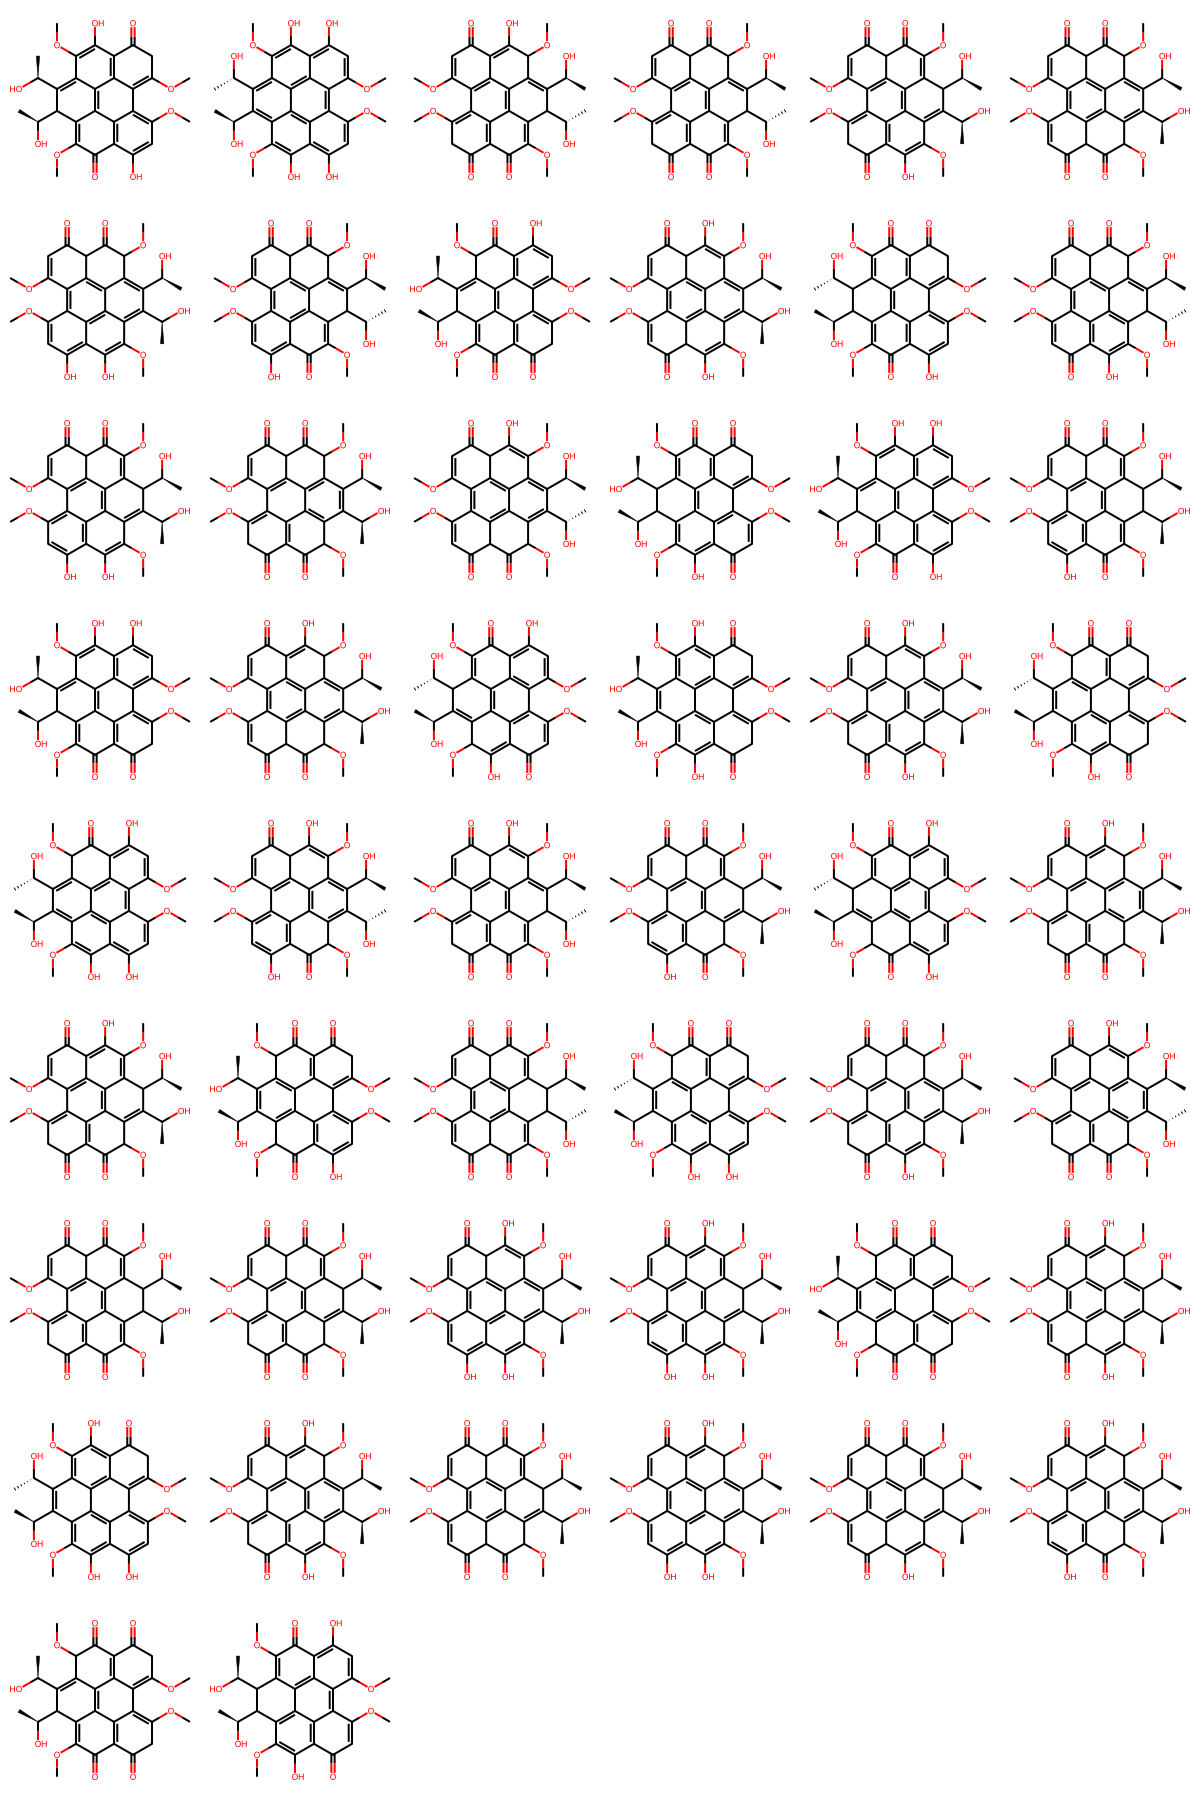

In [90]:
smls_tauts_example = df_melted_different_example.select("tautsTautomerEnumerator").item().to_list()
mols_tauts_example = [Chem.MolFromSmiles(sml) for sml in smls_tauts_example]
Draw.MolsToGridImage(mols_tauts_example, molsPerRow=6)

In [91]:
smls_v2 = df_melted_different_example.select("tautsTautomerEnumerator").item().to_list()
smls_v1 = df_melted_different_example.select("tautsGetV1TautomerEnumerator").item().to_list()
smls_v1_aligned = align_lists(smls_v2, smls_v1)
tauts_v2 = [Chem.MolFromSmiles(sml) for sml in smls_v2]
tauts_v1_aligned = [Chem.MolFromSmiles(sml) for sml in smls_v1_aligned]

print(f"{smls_v2=}")
print(f"{smls_v1_aligned=}")

smls_matrix = [smls_v2, smls_v1_aligned]
tauts_matrix = [tauts_v2, tauts_v1_aligned]

print(smls_matrix)
print(tauts_matrix)
Draw.MolsMatrixToGridImage(tauts_matrix, legendsMatrix=smls_matrix)

COC1=c2c(=C(C)O)c(C(C)O)c3c(OC)c(O)c4c5c(c6c(c2c53)=C(C(=O)CC6OC)C1=O)C(OC)CC4=O will be placed in column 65
C=C(O)c1c(C(C)O)c2c(OC)c(O)c3c(O)cc(OC)c4c5c6c(c(O)c(OC)c1c6c2c34)=C(O)CC5OC will be placed in column 66
C=C(O)c1c(C(C)O)c2c3c4c(c5c6c3c1=C(OC)C(=O)C6=C(O)CC=5OC)C(OC)CC(=O)C4C(O)=C2OC will be placed in column 67
COC1=CC(=O)c2c(O)c(OC)c3c4c2c1c1c(OC)cc(O)c2c(O)c(OC)c(c4c21)=C(C(C)O)C3C(C)O will be placed in column 68
COC1=c2c3c4c5c(c(C(C)O)c(C(C)=O)c6c5c2=C(C(=O)C1)C(=O)C6OC)C(OC)C(O)=C4C(O)=CC3OC will be placed in column 69
C=C(O)c1c(C(C)O)c2c3c4c(c5c6c(c(O)c(OC)c1c36)=C(O)CC5OC)C(OC)=CC(=O)C4=C(O)C2OC will be placed in column 70
C=C(O)c1c(C(C)O)c2c(OC)c(O)c3c4c(c5c6c(c1C(OC)C(=O)C=6C(O)=CC5OC)c24)C(OC)C=C3O will be placed in column 71
COc1c2c3c4c(c1=O)C(=O)CC(OC)c4c1c(OC)cc(=O)c4c(O)c(OC)c(c3c14)=C(C(C)O)C2C(C)O will be placed in column 72
COC1=CC(=O)c2c(O)c(OC)c3c(=C(C)O)c(C(C)O)c4c5c6c(c1c2c53)C(OC)C=C(O)C6C(O)=C4OC will be placed in column 73
COC1=c2c3c4c(c(O)c(OC)c5c(C(C)=

RuntimeError: File parsing error: PNG header not recognized

In [ ]:
# Optional--Checking data quality
df_1 = df.filter(pl.col("Ref")==1).select("Ref","Size",*numbered_columns[:4])
df_1
df_1_InChI = df_1.select("Ref",*InChI_columns[:2])
df_1_InChI = (
    df_1_InChI
    .melt(id_vars="Ref", value_vars=InChI_columns[:2], value_name="InChI")
    .select("InChI")
    .drop_nulls()
)
unique_InChI = set(df_1_InChI["InChI"].to_list())
print(f"{unique_InChI=}")

df_1_smls = df_1.select("Ref",*SMILES_columns[:2])

df_1_smls = (
    df_1_smls
    .melt(id_vars="Ref", value_vars=SMILES_columns[:2], value_name="sml")
    .select("sml")
    .drop_nulls()
)
unique_smls = df_1_smls["sml"].to_list()
unique_mols = [Chem.MolFromSmiles(sml) for sml in unique_smls]
unique_smls_canon = {Chem.MolToSmiles(mol) for mol in unique_mols}
unique_smls_to_inchi = {Chem.MolToInchi(mol) for mol in unique_mols}

print(f"{unique_smls_canon=}")
print(f"{unique_smls_to_inchi=}")

unique_InChI={'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3H2,1-2H3', 'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3,6H,1-2H3/b4-3-'}
unique_smls_canon={'CC(=O)CC(C)=O', 'CC(=O)/C=C(/C)O'}
unique_smls_to_inchi={'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3H2,1-2H3', 'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3,6H,1-2H3/b4-3-'}


Hi

In [ ]:
sml = "N=c1[nH]cc[nH]1"
smls_tauts = enumerate_tauts(sml)
smls_tauts
# check_same_keys(smls_tauts)

[{'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol at 0x12daae8f0>,
  'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol at 0x12daae960>},
 {'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol at 0x12daae880>,
  'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol at 0x12daaea40>}]

In [ ]:
for i in range(0,1000):
    smls_tauts = enumerate_tauts(sml)

[{'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x12daaec70>, 'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x12daaec00>}, {'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x12daaedc0>, 'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x12daaed50>}]
[['N=c1[nH]cc[nH]1', 'Nc1ncc[nH]1'], ['N=c1[nH]cc[nH]1', 'Nc1ncc[nH]1']]
[[<rdkit.Chem.rdchem.Mol object at 0x12daaec70>, <rdkit.Chem.rdchem.Mol object at 0x12daaec00>], [<rdkit.Chem.rdchem.Mol object at 0x12daaedc0>, <rdkit.Chem.rdchem.Mol object at 0x12daaed50>]]


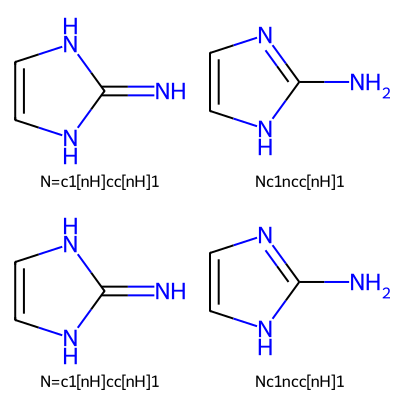

In [ ]:
sml = "N=c1[nH]cc[nH]1"
smls_tauts = enumerate_tauts(sml)
print(smls_tauts)
smls = [[item for item in enumerator.keys()] for enumerator in smls_tauts]
tauts = [[item for item in enumerator.values()] for enumerator in smls_tauts]

print(smls)
print(tauts)
Draw.MolsMatrixToGridImage(tauts, legendsMatrix=smls)